# Implicit Richards’ Equation Solver (ψ‑based)
**Governing equation (ψ‑form):**
$$
C(\psi)\,\frac{\partial \psi}{\partial t}
\;-\;\frac{\partial}{\partial z}\Bigl[K(\psi)\,\frac{\partial \psi}{\partial z}\Bigr]
\;-\;\frac{\partial K(\psi)}{\partial z}
\;=\;0
$$

- **ψ** = pressure head [cm]  
- **θ(ψ)** = volumetric water content [–]  
- **C(ψ)=dθ/dψ** = specific moisture capacity [1/cm]  
- **K(ψ)** = unsaturated hydraulic conductivity [cm/s]  

**Soil model:** van Genuchten–Mualem, parameters below.  
**Domain:** 125 cm depth (25 intervals of 5 cm)  
**Time:** up to 360 000 s (100 h), test Δt = [100,1000,2000] s  
**BCs:** top ponded ψ=0 cm, bottom fixed ψ=–202.528 cm  
**IC:** ψ=–202.528 cm initially

# INPUT DATA AND MODEL SETUP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ——— 1. DEFINE SOIL PARAMETERS ———
def setpars():
    """Return van Genuchten–Mualem soil params in a dict."""
    pars = {}
    pars['thetaR'] = 0.124     # residual water content [-]
    pars['thetaS'] = 0.495     # saturated water content [-]
    pars['alpha']  = 0.015     # inverse air-entry suction [1/cm]
    pars['m']      = 0.5       # VG shape param m = 1 - 1/n
    pars['n']      = 2.0       # VG shape param n
    pars['Ks']     = 1.23e-5   # saturated hydraulic conductivity [cm/s]
    return pars

# ——— 2. GRID & INITIAL/B.C. SETUP ———
def setup(dt):
    pars = setpars()
    # Spatial grid
    zN = 125              # total depth [cm]
    dz = 5                # grid spacing [cm]
    z  = np.arange(dz, zN, dz)  # exclude surface itself
    n  = len(z)           # number of nodes
    # Temporal grid
    tN = 360000           # total simulation time [s]
    t  = np.arange(0, tN+dt, dt)
    nt = len(t)
    # Allocate psi array (nt × n)
    psi = np.zeros((nt, n))
    psi[0, :] = -202.528116   # initial head hydrostatic
    # Boundary heads
    psiB = -202.528116  # bottom fixed head [cm]
    psiT = 0.0          # top ponded head [cm]
    return z, t, dz, n, nt, zN, psi, psiB, psiT, pars

# ——— 3. van Genuchten FUNCTIONS ———
def Cfun(psi, pars):
    """
    Specific moisture capacity C(ψ) = dθ/dψ.
    C = (θs-θr) * α n m (α|ψ|)^(n-1) / [1+(α|ψ|)^n]^(m+1).
    """
    θr, θs = pars['thetaR'], pars['thetaS']
    α, n, m = pars['alpha'], pars['n'], pars['m']
    x3 = 1.0 + (α*np.abs(psi))**n
    x2 = x3**(m+1)
    x1 = α*n*m * (α*np.abs(psi))**(n-1) / x2
    return (θs - θr) * x1

def Kfun(psi, pars):
    """
    Hydraulic conductivity K(ψ).
    Formula: Ks * [1 - (α|ψ|)^(n-1)/(1+(α|ψ|)^n)^m]^2 / (1+(α|ψ|)^n)^(m/2)
    """
    α, n, m, Ks = pars['alpha'], pars['n'], pars['m'], pars['Ks']
    x6 = 1.0 + (α*np.abs(psi))**n
    x5 = x6**(m*0.5)
    x4 = (α*np.abs(psi))**(n-1) * x6**(-m)
    x3 = 1.0 - x4
    x2 = x3**2
    return Ks * (x2 / x5)

def thetafun(psi, pars):
    """
    Volumetric water content θ(ψ).
    θ = θr + (θs-θr)/(1+(α|ψ|)^n)^m
    """
    θr, θs = pars['thetaR'], pars['thetaS']
    α, n, m = pars['alpha'], pars['n'], pars['m']
    x3 = 1.0 + (α*np.abs(psi))**n
    return θr + (θs - θr) / (x3**m)

# ——— 4. IMPLICIT SOLVER ———
def solverfun(psi, C, Kmid, dt, dz, n, psiT, psiB):
    """
    Assemble and solve A ψ^(n+1)=y for implicit FD.
    - a,b,c are tridiagonal diag arrays.
    - y includes flux divergence and BC corrections.
    """
    a = np.zeros(n)  # lower diag
    b = np.zeros(n)  # main diag
    c = np.zeros(n)  # upper diag
    y = np.zeros(n)  # RHS

    # Fill diagonals
    a[1:]  = -Kmid[1:-1] * dt / (C[1:] * dz**2)
    b[:]   = 1 + (Kmid[:-1]+Kmid[1:]) * dt / (C*dz**2)
    c[:-1] = -Kmid[1:-1] * dt / (C[:-1] * dz**2)

    # Assemble A
    A = np.diag(a[1:], -1) + np.diag(b,0) + np.diag(c[:-1],1)

    # RHS: ψ^n + (K_i+1 - K_i)*(dt/(C*dz))
    y[:] = psi + (Kmid[1:] - Kmid[:-1]) * dt / (C*dz)

    # Dirichlet BC injection
    y[0]  += psiB * Kmid[0]   * dt / (C[0]   * dz**2)
    y[-1] += psiT * Kmid[-1]  * dt / (C[-1]  * dz**2)

    # Solve linear system
    return np.linalg.solve(A, y)

def iterfun(psiin, pars, psiT, psiB, dt, dz, n):
    """
    One implicit time-step update:
      1) compute C(ψ^n)
      2) compute K on BC+nodes
      3) build mid-point Kmid
      4) solve for ψ^(n+1)
    """
    psiiter = psiin.copy()
    C_val   = Cfun(psiiter, pars)
    K_all   = Kfun(np.hstack([psiB, psiiter, psiT]), pars)
    Kmid    = (K_all[1:] + K_all[:-1]) / 2.0
    return solverfun(psiiter, C_val, Kmid, dt, dz, n, psiT, psiB)

def ModelRun(dt, dz, n, nt, psi, psiB, psiT, pars):
    """Advance through all time levels using iterfun."""
    for j in range(1, nt):
        psi[j,:] = iterfun(psi[j-1,:], pars, psiT, psiB, dt, dz, n)
    return psi

# SIMULATION RUN

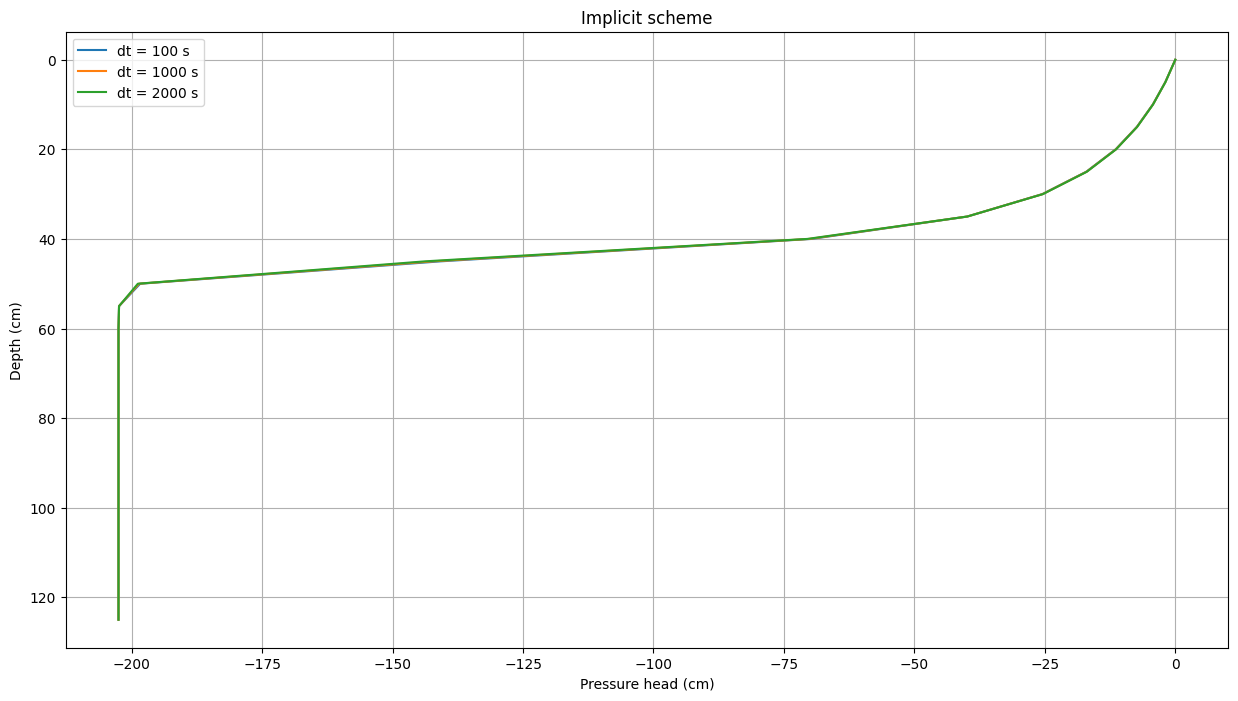

In [3]:
# ——— 5. RUN & PLOT ———
dt=np.array([100, 1000, 2000]) # Define different dt values

psi_results = {}

plt.figure(figsize=(15, 8))

for dti in dt:
    # build grids & init psi
    z,t,dz,n,nt,zN,psi,psiB,psiT,pars=setup(dti)
    psi = ModelRun(dti,dz,n,nt,psi,psiB,psiT,pars)
    # extract and plot final profile
    z=np.hstack([0,z,zN])
    z=z[-1]-z
    psi=np.hstack([psiB,psi[-1,:],psiT]) # Solve for psi

    psi_results[dti] = psi # Store psi values in the dictionary

    plt.plot(psi, z, label=f'dt = {dti} s')

plt.ylabel('Depth (cm)')
plt.xlabel('Pressure head (cm)')
plt.gca().invert_yaxis()
plt.title('Implicit scheme')
plt.legend()  # Show legend with dti values
plt.grid(True)
plt.show()

# RESULTS FOR ALL VARIABLES (theta, psi and K) AT LAST DEFINED TIME STEP (dt)

In [4]:
# ——— 6. OUTPUT TABLE ———
df_psi = pd.DataFrame(psi_results)  # Convert psi_results to DataFrame

# Add the 'z' values as the first column
df_psi.insert(0, 'z', z)
df_psi = df_psi.iloc[::-1]

print(df_psi)

      z         100        1000        2000
25    0    0.000000    0.000000    0.000000
24    5   -1.917218   -1.909341   -1.899761
23   10   -4.311417   -4.294584   -4.273934
22   15   -7.375477   -7.348585   -7.315172
21   20  -11.429318  -11.391720  -11.344019
20   25  -17.057670  -17.011077  -16.949464
19   30  -25.487268  -25.444142  -25.379266
18   35  -39.843127  -39.870101  -39.869121
17   40  -69.718119  -70.119422  -70.504571
16   45 -140.771192 -142.234914 -143.723366
15   50 -198.379189 -198.604900 -198.818854
14   55 -202.419282 -202.422967 -202.426257
13   60 -202.525464 -202.525483 -202.525489
12   65 -202.528053 -202.528052 -202.528050
11   70 -202.528115 -202.528114 -202.528114
10   75 -202.528116 -202.528116 -202.528116
9    80 -202.528116 -202.528116 -202.528116
8    85 -202.528116 -202.528116 -202.528116
7    90 -202.528116 -202.528116 -202.528116
6    95 -202.528116 -202.528116 -202.528116
5   100 -202.528116 -202.528116 -202.528116
4   105 -202.528116 -202.528116 